# Exploratory Data Analysis
## Project Group 12: Earth Systems Modeling
Charlotte Cherry

## Introduction

As a society, climate change is a predominant issue for political discussion. Understanding different climate projections and scenarios is of great importance for policy debates as decision makers grapple with uncertainty and trying to develop strategies that will influence the complex climate system. General Circulation Models (GCMs) are complex mathematical models that produce climate projections. These models are highly computaitonally demanding - taking long amounts of time and storage capacity to run over timescales of 100s of years. This can make GCMs impractical for many uses, particulalry policy analysis. Many potential users do not have the capacity to utilize GCMs as a tool on a typical computer or reasonable budget.

Given the supercomputing resources required to run earth systems models and climate models, there is a desire to use artificial intelligence to reduce this load. Climate emulators do just that by statistically replicating the nonlinear behavior of GCMs more quickly and with less computing power. By feeding inputs and outputs into a neural network, a program could identify patterns in the data and learn what different combinations of inputs tend to result in a particular outcome, without solving complex equations.

This project will utilize data science to develop a model that can replicate the results of a climate model using less resources. The model used is the Community Earth Systems Model (CESM). CESM represents urban areas well compared to other large earth systems models. In particular, the goal is to be able to emulate the climate model outputs related to temperature in "urban areas", as this is where the risk of heat waves in the future could have the greatest negative impacts on human health. Urban areas in this dataset refers loosely to areas where people live (i.e., not oceans or uninhabitable areas) but they do not actually correspond to just cities.

This exploratory data analysis will include steps to understand and describe the dataset, and understand the key variables included and their associated patterns. It focuses on identifying correlations and relationships among climate variables to identify which factors might be used to predict temperature results.

## Methods

The first step in the analysis is to import all of the necessary packages that will be used throughout. The best practice is to import them all at the beginning of the code.

In [268]:
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import networkx as nx
import xarray
import geopandas as gpd
from shapely.geometry import Point, Polygon
#from mpl_toolkits.basemap import Basemap
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

The exploratory data analysis will be completed using the training data set, which is a subset of the available data that will be used to develop the emulation model. 

This code brings in the training set, which is a csv file.

In [269]:
#IMPORTANT: Will need to change link to file
train = pd.read_csv(r'C:\Users\ckpch\Documents\University of Illinois Classes\Fall 2020\Data Science\Project\train.csv')
train

,lat,lon,time,mcdate,mcsec,mdcur,mscur,nstep,date_written,time_written,...,WOODC_LOSS,WOOD_HARVESTC,WOOD_HARVESTN,WTGQ,XSMRPOOL,XSMRPOOL_RECOVER,ZBOT,ZWT,ZWT_CH4_UNSAT,ZWT_PERCH
0,-55.130890,291.25,2015-02-01 00:00:00,20150201.0,0.0,31.0,0.0,1488.0,b'02/03/20',b'13:48:58',...,2.088290e-06,8.622255e-14,3.008571e-16,0.011096,-18.430012,5.077611e-06,30.0,0.679997,8.600000e+00,8.03
1,-54.188480,292.50,2015-02-01 00:00:00,20150201.0,0.0,31.0,0.0,1488.0,b'02/03/20',b'13:48:58',...,2.636426e-06,0.000000e+00,0.000000e+00,0.004370,-27.031332,7.277672e-06,30.0,8.576626,8.600000e+00,8.03
2,-53.246075,288.75,2015-02-01 00:00:00,20150201.0,0.0,31.0,0.0,1488.0,b'02/03/20',b'13:48:58',...,3.695520e-06,4.798560e-13,1.574547e-15,0.006048,-30.051014,7.530587e-06,30.0,8.482937,8.600000e+00,8.03
3,-53.246075,291.25,2015-02-01 00:00:00,20150201.0,0.0,31.0,0.0,1488.0,b'02/03/20',b'13:48:58',...,1.168498e-06,0.000000e+00,0.000000e+00,0.003439,-30.347467,7.589988e-06,30.0,8.599994,8.600000e+00,8.03
4,-51.361256,291.25,2015-02-01 00:00:00,20150201.0,0.0,31.0,0.0,1488.0,b'02/03/20',b'13:48:58',...,8.810783e-07,1.051186e-12,3.767686e-15,0.010660,-17.847149,4.376521e-06,30.0,8.600000,8.600000e+00,8.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392113,68.324608,32.50,2096-01-01 00:00:00,20960101.0,0.0,29565.0,0.0,1419120.0,b'02/05/20',b'14:46:53A\xb4\x0f*]\x19^d',...,5.908691e-06,0.000000e+00,0.000000e+00,0.000056,-103.447680,0.000000e+00,30.0,2.075583,6.084516e+00,0.01
392114,69.267014,18.75,2096-01-01 00:00:00,20960101.0,0.0,29565.0,0.0,1419120.0,b'02/05/20',b'14:46:53A\xb4\x0f*]\x19^d',...,3.311803e-06,0.000000e+00,0.000000e+00,0.000033,-72.102500,1.299642e-07,30.0,0.920000,1.476667e-08,0.01
392115,69.267014,32.50,2096-01-01 00:00:00,20960101.0,0.0,29565.0,0.0,1419120.0,b'02/05/20',b'14:46:53A\xb4\x0f*]\x19^d',...,2.307451e-06,0.000000e+00,0.000000e+00,0.000055,-81.472450,0.000000e+00,30.0,1.562245,3.171048e+00,0.01
392116,69.267014,87.50,2096-01-01 00:00:00,20960101.0,0.0,29565.0,0.0,1419120.0,b'02/05/20',b'14:46:53A\xb4\x0f*]\x19^d',...,1.102453e-06,0.000000e+00,0.000000e+00,0.000029,-45.448140,0.000000e+00,30.0,2.720000,0.000000e+00,0.01


The following few steps provide some basic information about the size and types of data that are within this dataset.

In [270]:
train.shape

(392118, 486)

In [271]:
train.dtypes

lat                 float64
lon                 float64
time                 object
mcdate              float64
mcsec               float64
                     ...   
XSMRPOOL_RECOVER    float64
ZBOT                float64
ZWT                 float64
ZWT_CH4_UNSAT       float64
ZWT_PERCH           float64
Length: 486, dtype: object

In [272]:
train.describe()

,lat,lon,mcdate,mcsec,mdcur,mscur,nstep,area,landfrac,landmask,...,WOODC_LOSS,WOOD_HARVESTC,WOOD_HARVESTN,WTGQ,XSMRPOOL,XSMRPOOL_RECOVER,ZBOT,ZWT,ZWT_CH4_UNSAT,ZWT_PERCH
count,392118.000000,392118.000000,3.921180e+05,392118.0,392118.000000,392118.0,3.921180e+05,344286.000000,344286.000000,344286.0,...,3.921180e+05,3.921180e+05,3.921180e+05,392118.000000,392118.000000,3.919690e+05,392118.000000,391969.000000,391969.000000,391969.000000
mean,19.171537,140.239360,2.051494e+07,0.0,13472.903901,0.0,6.466994e+05,11665.303742,0.849659,1.0,...,2.526306e-06,2.400359e-07,8.756213e-10,0.004051,-42.814683,8.408100e-06,24.082674,4.204694,5.755122,5.784402
std,33.834951,111.800522,2.460674e+05,0.0,8975.204148,0.0,4.308098e+05,2697.267256,0.285620,0.0,...,4.613472e-06,2.044490e-06,7.488670e-09,0.003435,39.785167,8.000968e-06,11.937562,3.316617,3.495249,3.466077
min,-90.000000,0.000000,2.015020e+07,0.0,31.000000,0.0,1.488000e+03,29.945992,0.001103,1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-243.856110,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.471204,40.000000,2.035080e+07,0.0,7512.000000,0.0,3.605760e+05,10341.876000,0.875168,1.0,...,5.895347e-11,0.000000e+00,0.000000e+00,0.000991,-67.899972,5.209009e-07,30.000000,0.920000,2.276654,0.978664
50%,26.858639,107.500000,2.045070e+07,0.0,11131.000000,0.0,5.342880e+05,12283.227000,1.000000,1.0,...,4.114946e-07,0.000000e+00,0.000000e+00,0.003587,-33.318898,6.663412e-06,30.000000,3.900000,7.658465,8.030000
75%,42.879581,261.250000,2.075050e+07,0.0,22020.000000,0.0,1.056960e+06,13823.684000,1.000000,1.0,...,3.596309e-06,0.000000e+00,0.000000e+00,0.006384,-7.994910,1.388630e-05,30.000000,7.641635,8.600000,8.030000
max,90.000000,358.750000,2.096010e+07,0.0,29565.000000,0.0,1.419120e+06,14566.216000,1.000000,1.0,...,1.433763e-04,1.014313e-04,3.749549e-07,0.024746,0.000000,4.150167e-05,30.000000,8.600000,8.600000,8.030000


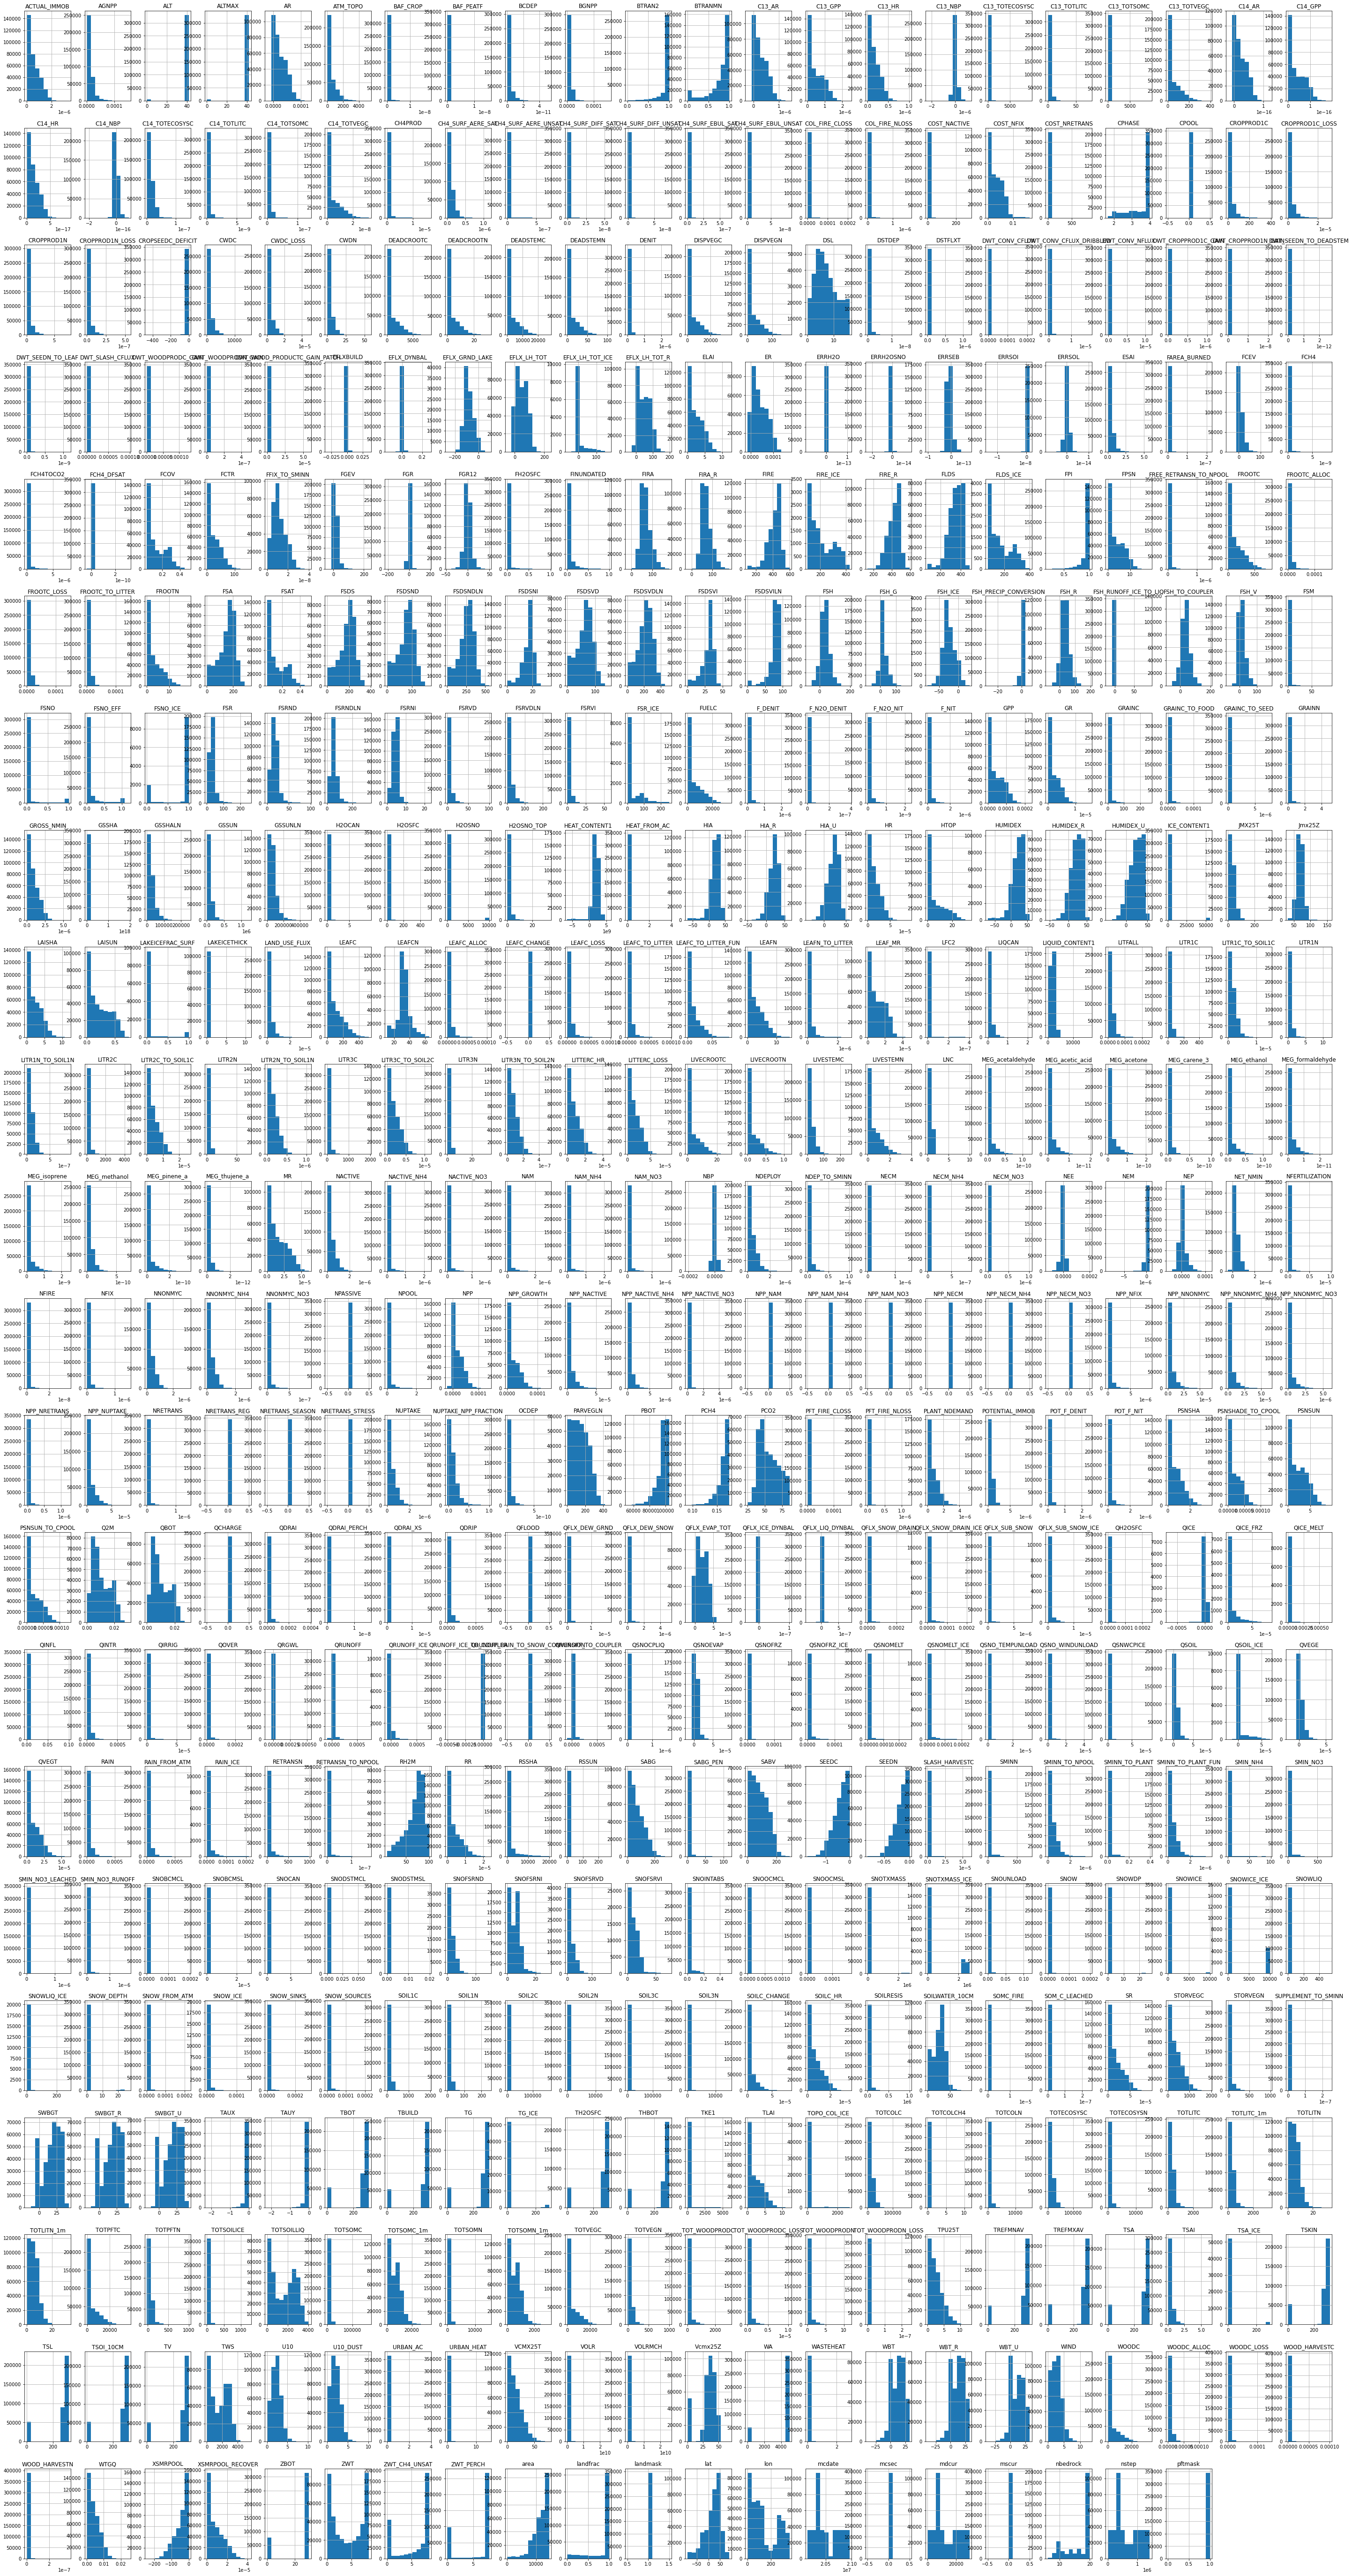

In [273]:
train.hist(figsize=(50,100));

In [274]:
type(train.time)

pandas.core.series.Series

The full training dataset is very large with 392118 rows and 486 columns. The rows represent the measurements taken at different locations around the globe and for different years. The columns represent nearly 500 variables generated by the climate model.

The many histograms created for the full dataset show that many of the variables only show a single value as the dominant value while others have a wider range of values. The variables with greater variation would be more interesting to look at.

First, we will focus on narrowing the variables down to the key variables of interest for this study to make it more manageable. We want to find which variables are most strongly correlated with temperature. The four variables considered here are:
* TSA - 2m air temperature
* SWBGT - 2m simplified wetbulb globe temp
* TSKIN - skin temperature
* TG - ground temperature

The most important variable that we are interested in replicating is TSA. However, there may be other interesting patterns with these other temperature variables to see if they have similarities or differences that would be informative in the model. So, a few temperature variables were selected to diversify the analysis.

In [275]:
#We want to find the correlations between each variable, which are shown in the following table
corr = train.corr()
corr

,lat,lon,mcdate,mcsec,mdcur,mscur,nstep,area,landfrac,landmask,...,WOODC_LOSS,WOOD_HARVESTC,WOOD_HARVESTN,WTGQ,XSMRPOOL,XSMRPOOL_RECOVER,ZBOT,ZWT,ZWT_CH4_UNSAT,ZWT_PERCH
lat,1.000000,-0.231125,0.091784,NaN,0.091163,NaN,0.091163,-0.225102,0.066599,NaN,...,0.019677,0.008929,0.007539,0.099771,-0.030738,-0.045131,0.280684,0.260216,0.235782,0.087670
lon,-0.231125,1.000000,-0.056586,NaN,-0.056201,NaN,-0.056201,0.091941,-0.074648,NaN,...,0.010104,-0.009056,-0.008521,-0.081027,-0.035036,0.057099,-0.173404,-0.174496,-0.202995,-0.084048
mcdate,0.091784,-0.056586,1.000000,NaN,0.999954,NaN,0.999954,0.095714,-0.014287,NaN,...,0.140497,0.010880,0.010877,0.193577,-0.265541,0.262271,0.330552,0.203290,0.270622,0.304492
mcsec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mdcur,0.091163,-0.056201,0.999954,NaN,1.000000,NaN,1.000000,0.095046,-0.014192,NaN,...,0.139064,0.009202,0.009206,0.192976,-0.263796,0.261665,0.328359,0.201832,0.269227,0.304287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XSMRPOOL_RECOVER,-0.045131,0.057099,0.262271,NaN,0.261665,NaN,0.261665,0.395881,-0.278593,NaN,...,0.534467,0.079222,0.082399,-0.002193,-0.802672,1.000000,0.521038,0.204794,0.314459,0.559992
ZBOT,0.280684,-0.173404,0.330552,NaN,0.328359,NaN,0.328359,0.421842,-0.061658,NaN,...,0.271437,0.058197,0.057959,0.584541,-0.533436,0.521038,1.000000,0.628569,0.816376,0.827435
ZWT,0.260216,-0.174496,0.203290,NaN,0.201832,NaN,0.201832,0.113629,-0.070553,NaN,...,0.051848,0.001657,0.001216,0.468230,-0.204924,0.204794,0.628569,1.000000,0.670111,0.497530
ZWT_CH4_UNSAT,0.235782,-0.202995,0.270622,NaN,0.269227,NaN,0.269227,0.323050,-0.045504,NaN,...,0.139071,0.021877,0.021879,0.622512,-0.317156,0.314459,0.816376,0.670111,1.000000,0.746316


In [276]:
#A subset of the correlation table rank the column with temperature to find highest correlation.
corr_temp = corr[['TSA','SWBGT','TSKIN','TG']].sort_values(by=['TSA'],ascending=False)
corr_temp.head(25)

,TSA,SWBGT,TSKIN,TG
TSA,1.000000,0.713573,0.999938,0.999899
TSA_ICE,0.999997,0.876098,0.999975,0.999960
TBOT,0.999995,0.712730,0.999905,0.999862
TG_ICE,0.999984,0.875652,0.999962,0.999944
TV,0.999967,0.715137,0.999974,0.999952
TSKIN,0.999938,0.715998,1.000000,0.999980
THBOT,0.999926,0.712355,0.999827,0.999792
TG,0.999899,0.716862,0.999980,1.000000
TREFMNAV,0.999883,0.714950,0.999756,0.999708
TSL,0.999856,0.713279,0.999913,0.999921


It is clear that there is a high correlation between many of these variables because they are all related to temperature. This should not be surprising because they represent multicollinearity and are controlled by similar earth processes. Multicollinearity refers to when there are two or more explanatory or dependent variables that are highly linearly related. It is important that we recognize where these relationships lie (which the EDA helps us do) because these variables should not be used in our model to predict TSA. Independent variables or drivers of temperature are needed as inputs for the model.

In order to develop the model, we will need to define independent variables such as solar radiation that can explain the patterns of these dependent variables. 

To make a shorter dataframe, the training dataset will be cut down to the columns with the highest correlation values for these variables, plus the defining columns with the location and time for the measurement. A few additional variables are added that are not highly correlated but could be independent variables that affect temperature (FSA - absorbed solar radiation, FSDS - atmospheric incident solar radiation, FLDS - atmospheric longwave radiation, HUMIDEX - 2 m Humidex, RAIN - atmospheric rain, after rain/snow repartitioning based on temperature, PBOT - atmospheric pressure at surface, QBOT - atmospheric specific humidity, RH2M - 2m relative humidity, SABG - solar rad absorbed by ground, U10 - 10-m wind)


In [277]:
df_short = train[['lat','lon','time','mcdate','FIRE_ICE', 'SOILWATER_10CM', 'SWBGT','SWBGT_R','SWBGT_U','TBOT','TBUILD','TG','TG_ICE','TH2OSFC','THBOT','TOPO_COL_ICE',
 'TREFMNAV','TREFMXAV','TSA','TSA_ICE','TSKIN','TSL','TSOI_10CM','TV','Vcmx25Z','WA','ZBOT','ZWT_CH4_UNSAT','ZWT_PERCH','U10','SABG','RH2M','HUMIDEX','FSA', 'FSDS', 'FLDS', 'RAIN', 'PBOT','QBOT']]
df_short.head()

,lat,lon,time,mcdate,FIRE_ICE,SOILWATER_10CM,SWBGT,SWBGT_R,SWBGT_U,TBOT,...,U10,SABG,RH2M,HUMIDEX,FSA,FSDS,FLDS,RAIN,PBOT,QBOT
0,-55.130890,291.25,2015-02-01 00:00:00,20150201.0,348.54828,33.829216,11.530669,11.546089,11.652277,280.17540,...,4.377486,45.099026,80.63163,6.670050,149.34387,177.45876,302.57727,0.000018,95531.490,0.005334
1,-54.188480,292.50,2015-02-01 00:00:00,20150201.0,NaN,15.742961,12.766111,12.748764,12.985643,282.17993,...,4.538742,28.940937,74.75783,8.796010,192.36288,222.94888,301.35184,0.000013,97154.766,0.005495
2,-53.246075,288.75,2015-02-01 00:00:00,20150201.0,357.91852,19.819775,13.357528,13.357226,13.540278,282.97974,...,4.960469,14.393866,75.53042,9.776310,161.38507,188.24068,308.13820,0.000019,96363.740,0.005852
3,-53.246075,291.25,2015-02-01 00:00:00,20150201.0,NaN,16.777815,13.693969,13.688558,13.927693,283.48350,...,5.553777,16.972063,73.58014,10.356051,190.60545,223.01390,305.19934,0.000007,97921.250,0.005836
4,-51.361256,291.25,2015-02-01 00:00:00,20150201.0,NaN,26.827670,14.503345,14.501535,14.673854,284.11948,...,4.688985,86.757240,73.83580,11.682140,191.89871,226.29799,311.43484,0.000009,99758.460,0.006193


In [292]:
#Insert a column with the correlation value
corr_tsa = corr_temp['TSA']
corr_tsa.to_frame()

,TSA
TSA,1.000000
TSA_ICE,0.999997
TBOT,0.999995
TG_ICE,0.999984
TV,0.999967
...,...
NRETRANS_SEASON,NaN
NRETRANS_STRESS,NaN
QCHARGE,NaN
QFLOOD,NaN


In [278]:
df_short['year']=pd.DatetimeIndex(df_short['time']).year
df_short['month']=pd.DatetimeIndex(df_short['time']).month -1
df_short

C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,lat,lon,time,mcdate,FIRE_ICE,SOILWATER_10CM,SWBGT,SWBGT_R,SWBGT_U,TBOT,...,RH2M,HUMIDEX,FSA,FSDS,FLDS,RAIN,PBOT,QBOT,year,month
0,-55.130890,291.25,2015-02-01 00:00:00,20150201.0,348.54828,33.829216,11.530669,11.546089,11.652277,280.17540,...,80.63163,6.670050,149.34387,177.45876,302.57727,1.769191e-05,95531.490,0.005334,2015,1
1,-54.188480,292.50,2015-02-01 00:00:00,20150201.0,NaN,15.742961,12.766111,12.748764,12.985643,282.17993,...,74.75783,8.796010,192.36288,222.94888,301.35184,1.288066e-05,97154.766,0.005495,2015,1
2,-53.246075,288.75,2015-02-01 00:00:00,20150201.0,357.91852,19.819775,13.357528,13.357226,13.540278,282.97974,...,75.53042,9.776310,161.38507,188.24068,308.13820,1.863059e-05,96363.740,0.005852,2015,1
3,-53.246075,291.25,2015-02-01 00:00:00,20150201.0,NaN,16.777815,13.693969,13.688558,13.927693,283.48350,...,73.58014,10.356051,190.60545,223.01390,305.19934,7.228879e-06,97921.250,0.005836,2015,1
4,-51.361256,291.25,2015-02-01 00:00:00,20150201.0,NaN,26.827670,14.503345,14.501535,14.673854,284.11948,...,73.83580,11.682140,191.89871,226.29799,311.43484,8.997939e-06,99758.460,0.006193,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392113,68.324608,32.50,2096-01-01 00:00:00,20960101.0,NaN,52.741478,1.830776,1.846076,2.528475,267.83688,...,98.05147,-9.778364,0.00000,0.00000,234.97035,1.263064e-06,98575.930,0.002521,2096,0
392114,69.267014,18.75,2096-01-01 00:00:00,20960101.0,NaN,63.764652,0.715020,0.711479,1.727049,266.34766,...,98.57366,-11.690122,0.00000,0.00000,236.38500,8.234587e-06,97764.880,0.002325,2096,0
392115,69.267014,32.50,2096-01-01 00:00:00,20960101.0,NaN,55.564440,2.558871,2.556589,3.351141,268.74518,...,98.07002,-8.538774,0.00000,0.00000,245.46834,2.799681e-06,99749.270,0.002699,2096,0
392116,69.267014,87.50,2096-01-01 00:00:00,20960101.0,NaN,59.676530,-4.922259,-4.913755,-4.508545,256.43228,...,97.62277,-21.396603,0.00000,0.00000,217.73500,0.000000e+00,101560.875,0.001127,2096,0


In [279]:
df_short['year'].value_counts()

2035    103891
2045     32824
2075     32753
2055     32742
2095     32713
2015     32696
2025     32685
2085     32636
2065     32504
2016      3003
2056      3000
2076      2984
2036      2980
2096      2959
2026      2959
2086      2948
2066      2941
2046      2900
Name: year, dtype: int64

The data represent one year of data for every 10 years (2015-2095). In order to see the if there is an obvious change in temperature over time, it is helpful to create a line plot of TSA throughout the full span of the data. In addition, there seems to be a disproportionate number of data points for 2035, which needs to be explored more to make sure that this is not an issue.

C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


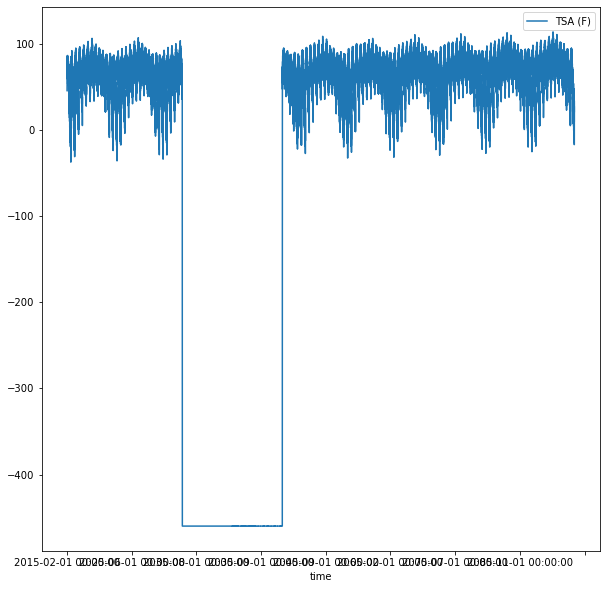

In [280]:
#Convert temperature from Kelvin to Fahrenheit for easier visualization
df_short['TSA (F)']=(df_short.TSA-273.15)*9/5 + 32
#Plot time against temperature
df_short.plot(x='time',y='TSA (F)', figsize=(10,10));

The figure above clearly shows that there is a set of outliers in the data that need to be removed in order to properly analyze these data. 

In [281]:
outlier = df_short[df_short['year'] == 2035]
outlier = outlier.sort_values(by=['TSA (F)'], ascending=True)
outlier

,lat,lon,time,mcdate,FIRE_ICE,SOILWATER_10CM,SWBGT,SWBGT_R,SWBGT_U,TBOT,...,HUMIDEX,FSA,FSDS,FLDS,RAIN,PBOT,QBOT,year,month,TSA (F)
110569,9.895288,355.00,2035-08-01 00:00:00,20350801.0,NaN,0.0,0.0,0.0,0.0,0.0,...,38.641370,161.55258,189.65855,408.41992,0.000045,97648.70,0.019174,2035,7,-459.67
106951,-6.125654,37.50,2035-08-01 00:00:00,20350801.0,NaN,0.0,0.0,0.0,0.0,0.0,...,24.360308,163.12903,191.30281,366.00763,0.000002,92760.93,0.009964,2035,7,-459.67
106952,-6.125654,38.75,2035-08-01 00:00:00,20350801.0,NaN,0.0,0.0,0.0,0.0,0.0,...,31.354012,150.10594,176.08032,392.29523,0.000007,100443.09,0.012817,2035,7,-459.67
106953,-6.125654,40.00,2035-08-01 00:00:00,20350801.0,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035,7,-459.67
106954,-6.125654,42.50,2035-08-01 00:00:00,20350801.0,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035,7,-459.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165882,88.115181,216.25,2035-09-01 00:00:00,20350901.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035,8,NaN
165883,88.115181,217.50,2035-09-01 00:00:00,20350901.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035,8,NaN
165884,88.115181,218.75,2035-09-01 00:00:00,20350901.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035,8,NaN
165885,88.115181,220.00,2035-09-01 00:00:00,20350901.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035,8,NaN


In [282]:
#This code removes all rows for which the temperature is an na value
df_nona = df_short.dropna(subset = ['TSA (F)'])
df_nona.shape

(366681, 42)

In [283]:
df_nona['TSA (F)'].describe()
#We can see that the range of temperature goes to an unrealistic -459 degrees F so these are clearly not legitimate data points and should be removed.

count    366681.000000
mean         -8.590572
std         184.103622
min        -459.670000
25%          39.948980
50%          66.015914
75%          80.257334
max         113.723492
Name: TSA (F), dtype: float64

In [284]:
#This cuts out all of the rows where the temperature is below -400 degrees F
low_values = df_nona[df_nona['TSA (F)'] < -400].index
df_nona.drop(low_values, inplace = True)
df_nona.head()

C:\Users\ckpch\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,lat,lon,time,mcdate,FIRE_ICE,SOILWATER_10CM,SWBGT,SWBGT_R,SWBGT_U,TBOT,...,HUMIDEX,FSA,FSDS,FLDS,RAIN,PBOT,QBOT,year,month,TSA (F)
0,-55.130890,291.25,2015-02-01 00:00:00,20150201.0,348.54828,33.829216,11.530669,11.546089,11.652277,280.17540,...,6.670050,149.34387,177.45876,302.57727,0.000018,95531.490,0.005334,2015,1,45.560570
1,-54.188480,292.50,2015-02-01 00:00:00,20150201.0,NaN,15.742961,12.766111,12.748764,12.985643,282.17993,...,8.796010,192.36288,222.94888,301.35184,0.000013,97154.766,0.005495,2015,1,49.002368
2,-53.246075,288.75,2015-02-01 00:00:00,20150201.0,357.91852,19.819775,13.357528,13.357226,13.540278,282.97974,...,9.776310,161.38507,188.24068,308.13820,0.000019,96363.740,0.005852,2015,1,50.310680
3,-53.246075,291.25,2015-02-01 00:00:00,20150201.0,NaN,16.777815,13.693969,13.688558,13.927693,283.48350,...,10.356051,190.60545,223.01390,305.19934,0.000007,97921.250,0.005836,2015,1,51.255140
4,-51.361256,291.25,2015-02-01 00:00:00,20150201.0,NaN,26.827670,14.503345,14.501535,14.673854,284.11948,...,11.682140,191.89871,226.29799,311.43484,0.000009,99758.460,0.006193,2015,1,52.905164


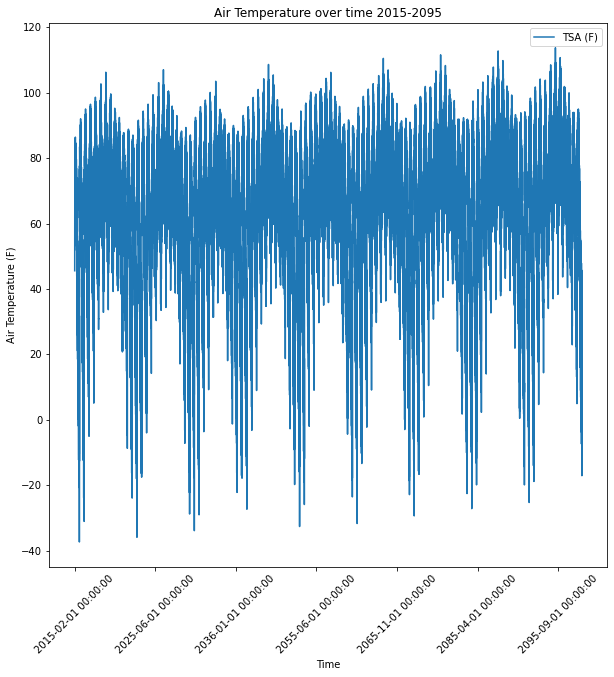

In [296]:
#Plot time against temperature with outliers removed
#This plot demonstrates that the outliers have been removed and the data looks more consistent
df_nona.plot(x='time',y='TSA (F)', figsize=(10,10))
plt.title("Air Temperature over time 2015-2095")
plt.xlabel('Time')
plt.ylabel("Air Temperature (F)")
plt.xticks(rotation=45);

In [320]:
grouped_df = df_nona.groupby("year")
maximum = grouped_df['TSA (F)'].max()
maximum = maximum.reset_index()
maximum = maximum.drop([1, 3,5,7,9,11,13,15,17])
maximum

,year,TSA (F)
0,2015,106.254554
2,2025,107.019140
4,2035,103.495100
6,2045,108.628340
8,2055,106.216916
10,2065,110.489072
12,2075,111.567380
14,2085,112.756748
16,2095,113.723492


In [321]:
minimum = grouped_df['TSA (F)'].min()
minimum = minimum.reset_index()
minimum = minimum.drop([1, 3,5,7,9,11,13,15,17])
minimum

,year,TSA (F)
0,2015,-37.354864
2,2025,-35.919274
4,2035,-33.901600
6,2045,-27.343462
8,2055,-32.631268
10,2065,-31.711540
12,2075,-29.384446
14,2085,-27.173254
16,2095,-25.284532


In [322]:
mean = grouped_df['TSA (F)'].mean()
mean = mean.reset_index()
mean = mean.drop([1, 3,5,7,9,11,13,15,17])
mean

,year,TSA (F)
0,2015,64.069811
2,2025,64.683846
4,2035,63.135482
6,2045,66.050853
8,2055,66.777456
10,2065,67.668224
12,2075,68.618606
14,2085,69.684940
16,2095,70.499549


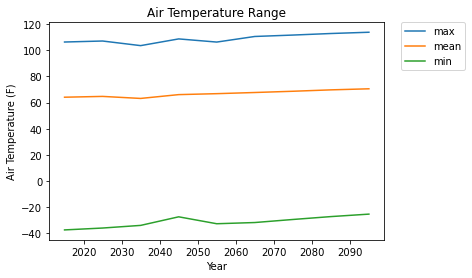

In [341]:
fig = plt.figure()
ax = plt.axes()
ax.plot(maximum.year, maximum['TSA (F)'], label='max')
ax.plot(maximum.year, mean['TSA (F)'], label='mean')
ax.plot(maximum.year, minimum['TSA (F)'], label='min')
plt.xlabel('Year')
plt.ylabel('Air Temperature (F)')
plt.title('Air Temperature Range')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

The figure above shows that There is a slight upward trend in the maximum, mean, and minimum annual temperature over the time range of projections. 

The way that the time column is formated is for the month following the model results (i.e., January 2015 is listed as 2015-02-01). Therefore, there are actually times listed for the following year (December 2015 becomes 2015-01-01). This is because the time coordinates for CESM represent the end of the averaging period for variables. This will need to be accounted for when analyzing the data. The code above breaks out the year and month values for each row so that separate dataframes can be created for each year. 

The following analysis will break the large dataframe down to yearly datafrarme. In addition, the last date is translated so that it is December of the previous year. Analysis on average temperatures for each year can be used to see how temperature projections change over time. Three years representing the first, middle, and last years available were selected so that the difference could be compared to see how the projections change over the span of the projections.

### Analysis of 2015

In [297]:
df_2015=df_nona[df_nona['year']==2015]
df_2016=df_nona[df_nona['year']==2016]
df_2016['year']=2015
df_2016['month']=12
df_2015 = df_2015.append(df_2016)
df_2015.head()

C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,lat,lon,time,mcdate,FIRE_ICE,SOILWATER_10CM,SWBGT,SWBGT_R,SWBGT_U,TBOT,...,HUMIDEX,FSA,FSDS,FLDS,RAIN,PBOT,QBOT,year,month,TSA (F)
0,-55.130890,291.25,2015-02-01 00:00:00,20150201.0,348.54828,33.829216,11.530669,11.546089,11.652277,280.17540,...,6.670050,149.34387,177.45876,302.57727,0.000018,95531.490,0.005334,2015,1,45.560570
1,-54.188480,292.50,2015-02-01 00:00:00,20150201.0,NaN,15.742961,12.766111,12.748764,12.985643,282.17993,...,8.796010,192.36288,222.94888,301.35184,0.000013,97154.766,0.005495,2015,1,49.002368
2,-53.246075,288.75,2015-02-01 00:00:00,20150201.0,357.91852,19.819775,13.357528,13.357226,13.540278,282.97974,...,9.776310,161.38507,188.24068,308.13820,0.000019,96363.740,0.005852,2015,1,50.310680
3,-53.246075,291.25,2015-02-01 00:00:00,20150201.0,NaN,16.777815,13.693969,13.688558,13.927693,283.48350,...,10.356051,190.60545,223.01390,305.19934,0.000007,97921.250,0.005836,2015,1,51.255140
4,-51.361256,291.25,2015-02-01 00:00:00,20150201.0,NaN,26.827670,14.503345,14.501535,14.673854,284.11948,...,11.682140,191.89871,226.29799,311.43484,0.000009,99758.460,0.006193,2015,1,52.905164


C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


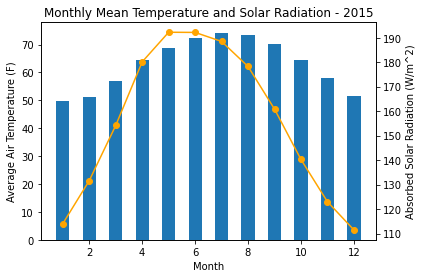

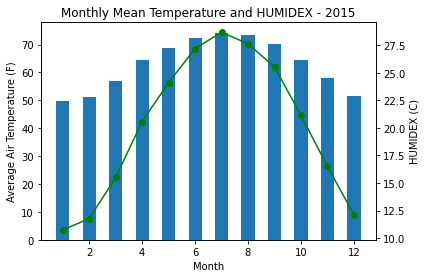

In [382]:
#Plot the monthly distribution of mean temperature
monthly_2015 = df_2015.groupby("month")
fsa_monthly2015 = monthly_2015['FSA'].mean()
fsa_monthly2015=fsa_monthly2015.to_frame()
mean_monthly2015 = monthly_2015['TSA (F)'].mean()
mean_monthly2015 = mean_monthly2015.reset_index()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(mean_monthly2015.month,mean_monthly2015['TSA (F)'].values, width=0.5)
ax2 = fig.add_subplot(111)
ax2 = ax.twinx()
ax2.plot(mean_monthly2015.month,fsa_monthly2015['FSA'].values, marker='o', color='orange')
ax.set_xlabel('Month')
ax.set_ylabel('Average Air Temperature (F)')
ax2.set_ylabel('Absorbed Solar Radiation (W/m^2)')
plt.title('Monthly Mean Temperature and Solar Radiation - 2015');


C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


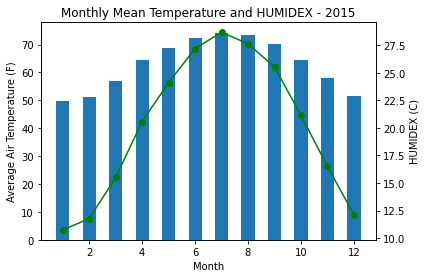

In [410]:
humidex_monthly2015 = monthly_2015['HUMIDEX'].mean()
humidex_monthly2015=humidex_monthly2015.to_frame()
fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.bar(mean_monthly2015.month,mean_monthly2015['TSA (F)'].values, width=0.5)
ax2 = fig2.add_subplot(111)
ax2 = ax.twinx()
ax2.plot(mean_monthly2015.month,humidex_monthly2015['HUMIDEX'].values, marker='o', color='green')
ax.set_xlabel('Month')
ax.set_ylabel('Average Air Temperature (F)')
ax2.set_ylabel('HUMIDEX (C)')
plt.title('Monthly Mean Temperature and HUMIDEX - 2015');

C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


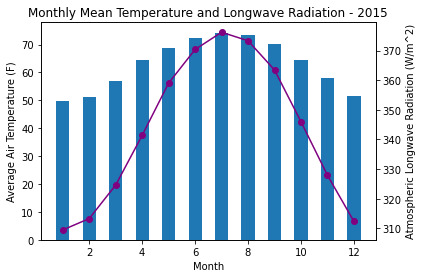

In [429]:
FLDS_monthly2015 = monthly_2015['FLDS'].mean()
FLDS_monthly2015=FLDS_monthly2015.to_frame()
fig3 = plt.figure()
ax = fig3.add_subplot(111)
ax.bar(mean_monthly2015.month,mean_monthly2015['TSA (F)'].values, width=0.5)
ax2 = fig3.add_subplot(111)
ax2 = ax.twinx()
ax2.plot(mean_monthly2015.month,FLDS_monthly2015['FLDS'].values, marker='o', color='purple')
ax.set_xlabel('Month')
ax.set_ylabel('Average Air Temperature (F)')
ax2.set_ylabel('Atmospheric Longwave Radiation (W/m^2)')
plt.title('Monthly Mean Temperature and Longwave Radiation - 2015');

In [387]:
monthly_2015['TG'].describe()

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,2947.0,284.354661,14.727064,236.05943,272.390700,284.105500,299.025390,307.86404
2,2967.0,285.527730,15.688630,237.87988,272.758235,287.154050,300.276685,311.39954
3,2991.0,289.004408,13.426314,252.18433,278.565775,290.245820,301.279400,313.11740
4,2957.0,293.278869,10.041055,257.50266,285.531070,293.361850,301.889600,314.38873
5,2983.0,296.103157,7.885593,269.76266,289.935975,295.708920,302.123420,314.76530
6,2981.0,297.798595,6.935920,272.04470,292.812840,298.038850,302.588300,314.19443
7,3004.0,298.728909,6.369320,272.71720,294.075852,299.634950,303.167807,316.35300
8,2985.0,298.446010,6.150400,273.18670,294.027000,299.384520,302.774800,313.21640
9,2959.0,296.514062,6.682395,277.16013,291.063710,297.690460,301.843200,310.79947


C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


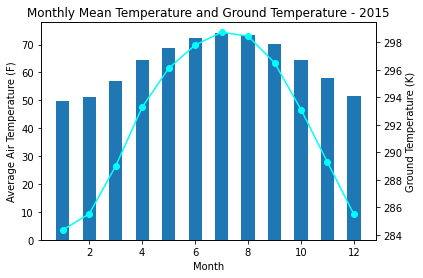

In [405]:
TG_monthly2015=monthly_2015['TG'].mean()
TG_monthly2015=TG_monthly2015.to_frame()
fig4 = plt.figure()
ax = fig4.add_subplot(111)
ax.bar(mean_monthly2015.month,mean_monthly2015['TSA (F)'].values, width=0.5)
ax2 = fig4.add_subplot(111)
ax2 = ax.twinx()
ax2.plot(mean_monthly2015.month,TG_monthly2015['TG'].values, marker='o', color='cyan')
ax.set_xlabel('Month')
ax.set_ylabel('Average Air Temperature (F)')
ax2.set_ylabel('Ground Temperature (K)')
plt.title('Monthly Mean Temperature and Ground Temperature - 2015');

C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


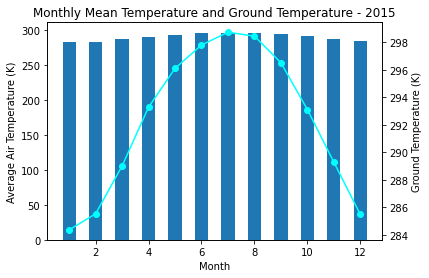

In [428]:
TG_monthly2015=monthly_2015['TG'].mean()
TG_monthly2015=TG_monthly2015.to_frame()
mean_monthlyK2015 = monthly_2015['TSA'].mean()
mean_monthlyK2015 = mean_monthlyK2015.reset_index()
fig5 = plt.figure()
ax = fig5.add_subplot(111)
ax.bar(mean_monthlyK2015.month,mean_monthlyK2015['TSA'].values, width=0.5)
ax2 = fig5.add_subplot(111)
ax2 = ax.twinx()
ax2.plot(mean_monthlyK2015.month,TG_monthly2015['TG'].values, marker='o', color='cyan')
ax.set_xlabel('Month')
ax.set_ylabel('Average Air Temperature (K)')
ax2.set_ylabel('Ground Temperature (K)')
plt.title('Monthly Mean Temperature and Ground Temperature - 2015');

C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


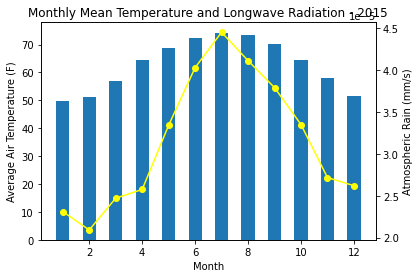

In [427]:
rain_monthly2015 = monthly_2015['RAIN'].mean()
rain_monthly2015=rain_monthly2015.to_frame()
fig6 = plt.figure()
ax = fig6.add_subplot(111)
ax.bar(mean_monthly2015.month,mean_monthly2015['TSA (F)'].values, width=0.5)
ax2 = fig6.add_subplot(111)
ax2 = ax.twinx()
ax2.plot(mean_monthly2015.month,rain_monthly2015['RAIN'].values, marker='o', color='yellow')
ax.set_xlabel('Month')
ax.set_ylabel('Average Air Temperature (F)')
ax2.set_ylabel('Atmospheric Rain (mm/s)')
plt.title('Monthly Mean Temperature and Longwave Radiation - 2015');

The graphs above do not show an obvious relationship between temperature and some of the other possible independent variables. Most of the variables explored, particularly those related to solar radiation, demonstrated a bell-shaped curve, which is to be expected when examined on a global scale. Thus, it might be necessary to break these data down spatially to explore differences in how these relationships are experienced at different latitudes. Rainfall shows an interesting pattern that could be explored further, as the curve is not smooth. Temperature has the expected histogram shape with warmer temperatures in the middle of the year and colder in the "winter" of the northern hemisphere. This is also possibly misleading as these are global data and there would be drastic differences between the temperature experienced in each month in the northern and southern hemispheres. However, we will explore below the spatial distribution of data which explains that population density is concentrated in the northern hemisphere, which likely skews the data.

The next section converts the data to a geodataframe so that the data points can be mapped on the globe.

In [415]:
points = df_2015.apply(lambda row: Point(row.lon, row.lat), axis=1)
geo_temp2015 = gpd.GeoDataFrame(df_2015, geometry=points)
geo_temp2015.set_crs(epsg=4326)
geo_temp2015.time = pd.to_datetime(geo_temp2015.time)
geo_temp2015.head()

,lat,lon,time,mcdate,FIRE_ICE,SOILWATER_10CM,SWBGT,SWBGT_R,SWBGT_U,TBOT,...,FSA,FSDS,FLDS,RAIN,PBOT,QBOT,year,month,TSA (F),geometry
0,-55.130890,291.25,2015-02-01,20150201.0,348.54828,33.829216,11.530669,11.546089,11.652277,280.17540,...,149.34387,177.45876,302.57727,0.000018,95531.490,0.005334,2015,1,45.560570,POINT (291.250 -55.131)
1,-54.188480,292.50,2015-02-01,20150201.0,NaN,15.742961,12.766111,12.748764,12.985643,282.17993,...,192.36288,222.94888,301.35184,0.000013,97154.766,0.005495,2015,1,49.002368,POINT (292.500 -54.188)
2,-53.246075,288.75,2015-02-01,20150201.0,357.91852,19.819775,13.357528,13.357226,13.540278,282.97974,...,161.38507,188.24068,308.13820,0.000019,96363.740,0.005852,2015,1,50.310680,POINT (288.750 -53.246)
3,-53.246075,291.25,2015-02-01,20150201.0,NaN,16.777815,13.693969,13.688558,13.927693,283.48350,...,190.60545,223.01390,305.19934,0.000007,97921.250,0.005836,2015,1,51.255140,POINT (291.250 -53.246)
4,-51.361256,291.25,2015-02-01,20150201.0,NaN,26.827670,14.503345,14.501535,14.673854,284.11948,...,191.89871,226.29799,311.43484,0.000009,99758.460,0.006193,2015,1,52.905164,POINT (291.250 -51.361)


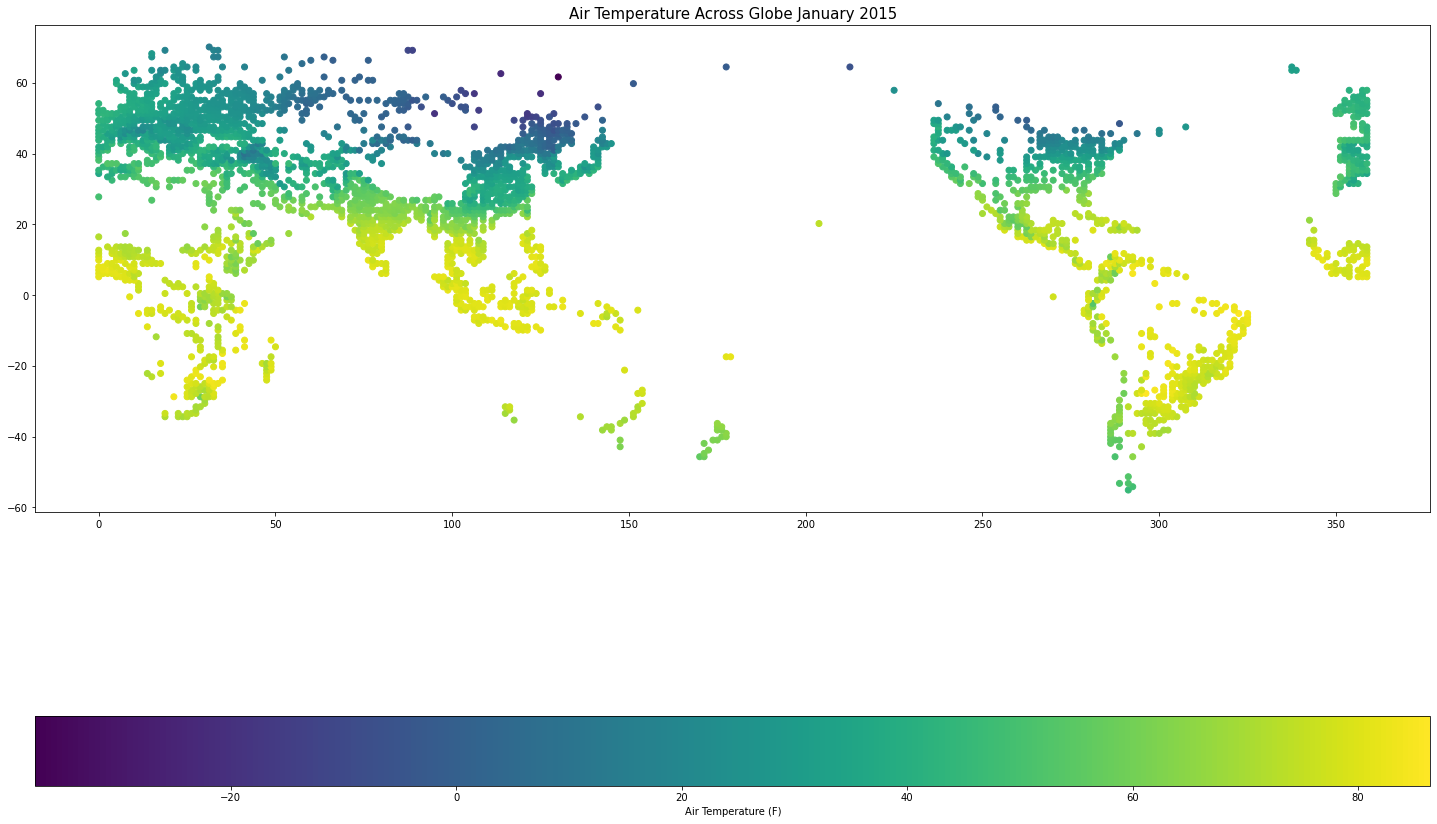

In [416]:
#Map for January
tsa2015_01 = geo_temp2015[geo_temp2015.month ==1]
tsa2015_01 = gpd.GeoDataFrame(tsa2015_01, geometry = points)

tsa2015_01.plot(column='TSA (F)', figsize=(25,25), legend=True, legend_kwds={'label': "Air Temperature (F)","orientation":"horizontal"})
plt.title('Air Temperature Across Globe January 2015', fontsize=15);

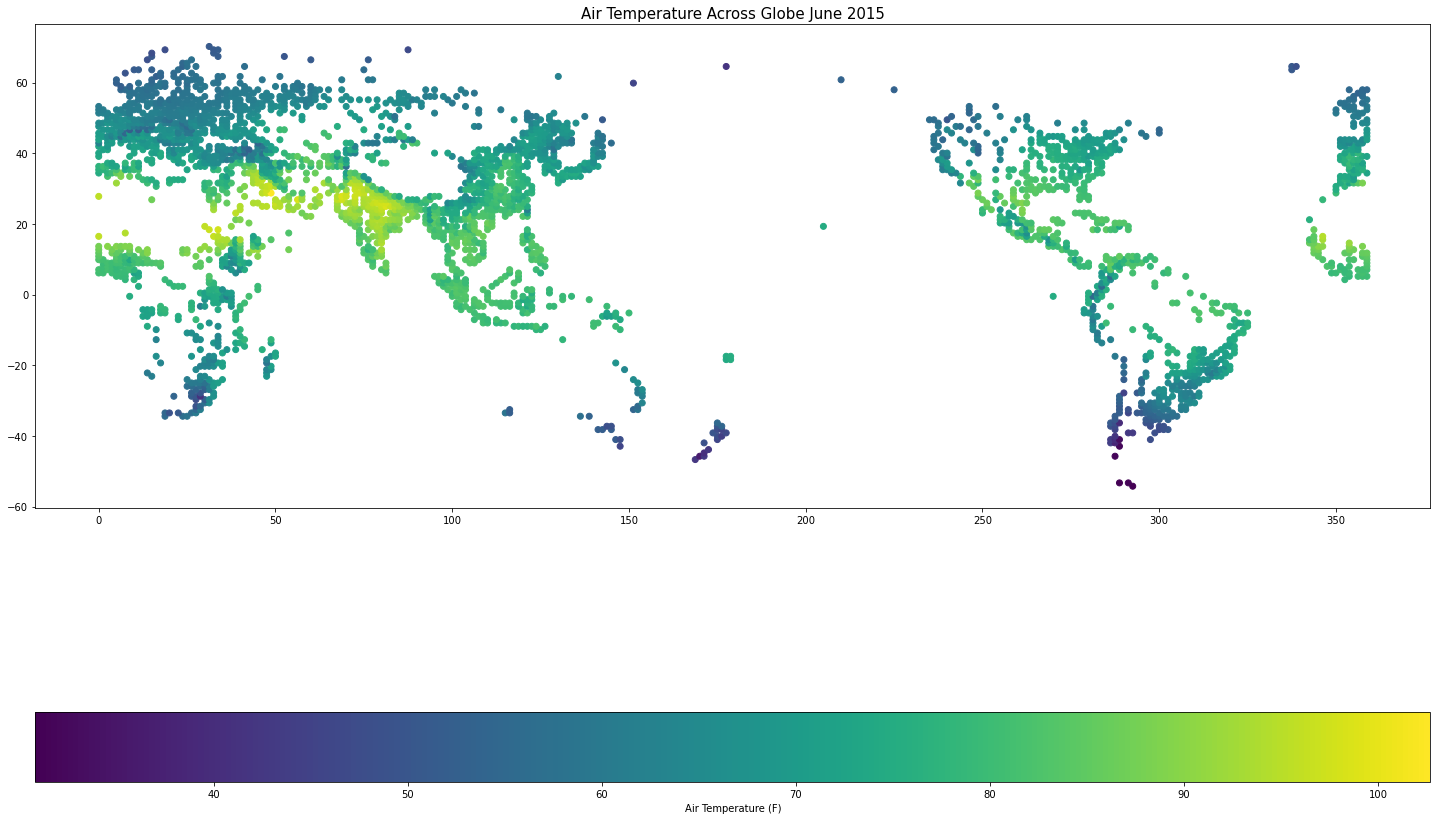

In [417]:
#Map for June
tsa2015_06 = geo_temp2015[geo_temp2015.month ==6]
tsa2015_06 = gpd.GeoDataFrame(tsa2015_06, geometry = points)

tsa2015_06.plot(column='TSA (F)', figsize=(25,25), legend=True, legend_kwds={'label': "Air Temperature (F)","orientation":"horizontal"})
plt.title('Air Temperature Across Globe June 2015', fontsize=15);

The global map of data for January shows a strong north-south divide, with latitudes below 20 degrees showing much warmer temperatures. However, when the temperature data are mapped for June, the warmer temperatures are in the center of the map but there is a smaller range of temperatures shown across the globe.

In [440]:
df_2015['lat'].describe()

count    35699.000000
mean        23.921041
std         25.361023
min        -55.130890
25%          8.952880
50%         29.685863
75%         42.879581
max         70.209427
Name: lat, dtype: float64

In [445]:
df_2015['bin']=pd.qcut(df_2015['lat'], q=24)
df_2015['bin'].value_counts()

(50.419, 54.188]      1873
(20.262, 24.031]      1778
(32.513, 35.34]       1698
(8.953, 12.723]       1675
(4.241, 8.953]        1650
(44.764, 47.592]      1615
(29.686, 32.513]      1572
(-29.686, -20.262]    1565
(-55.132, -29.686]    1539
(-20.262, -8.953]     1487
(39.11, 40.995]       1485
(-8.953, -2.356]      1483
(16.492, 20.262]      1452
(24.031, 26.859]      1452
(35.34, 37.225]       1417
(57.016, 70.209]      1411
(40.995, 42.88]       1403
(-2.356, 4.241]       1370
(12.723, 16.492]      1361
(47.592, 50.419]      1342
(42.88, 44.764]       1314
(26.859, 29.686]      1301
(37.225, 39.11]       1295
(54.188, 57.016]      1161
Name: bin, dtype: int64

### Analysis of 2055

In [419]:
df_2055=df_nona[df_nona['year']==2055]
df_2056=df_nona[df_nona['year']==2056]
df_2056['year']=2055
df_2056['month']=12
df_2055 = df_2055.append(df_2056)
df_2055.head()

C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,lat,lon,time,mcdate,FIRE_ICE,SOILWATER_10CM,SWBGT,SWBGT_R,SWBGT_U,TBOT,...,HUMIDEX,FSA,FSDS,FLDS,RAIN,PBOT,QBOT,year,month,TSA (F)
213938,-55.130890,291.25,2055-02-01 00:00:00,20550201.0,353.0976,33.374546,12.332594,12.346349,12.467683,281.21533,...,7.998721,140.89810,167.90002,308.36210,0.000017,95664.450,0.005730,2055,1,47.329484
213939,-54.188480,292.50,2055-02-01 00:00:00,20550201.0,NaN,16.648280,13.601263,13.583038,13.834242,283.21440,...,10.179161,187.87909,217.97440,308.08035,0.000012,97281.660,0.005916,2055,1,50.839448
213940,-53.246075,291.25,2055-02-01 00:00:00,20550201.0,NaN,16.581320,14.581909,14.576223,14.830126,284.61255,...,11.834246,189.00864,221.09010,312.11102,0.000007,98037.945,0.006245,2055,1,53.277368
213941,-51.361256,291.25,2055-02-01 00:00:00,20550201.0,NaN,22.337399,15.373065,15.370732,15.592875,285.20798,...,13.106746,189.75154,223.65970,318.95416,0.000009,99856.060,0.006652,2055,1,54.674960
213942,-49.476440,292.50,2055-02-01 00:00:00,20550201.0,NaN,16.505436,17.916601,17.915420,17.988306,288.72696,...,17.447790,214.86821,253.39426,328.66174,0.000021,99849.820,0.007379,2055,1,61.435436


In [420]:
points = df_2055.apply(lambda row: Point(row.lon, row.lat), axis=1)
geo_temp2055 = gpd.GeoDataFrame(df_2055, geometry=points)
geo_temp2055.set_crs(epsg=4326)
geo_temp2055.time = pd.to_datetime(geo_temp2055.time)
geo_temp2055.head()

,lat,lon,time,mcdate,FIRE_ICE,SOILWATER_10CM,SWBGT,SWBGT_R,SWBGT_U,TBOT,...,FSA,FSDS,FLDS,RAIN,PBOT,QBOT,year,month,TSA (F),geometry
213938,-55.130890,291.25,2055-02-01,20550201.0,353.0976,33.374546,12.332594,12.346349,12.467683,281.21533,...,140.89810,167.90002,308.36210,0.000017,95664.450,0.005730,2055,1,47.329484,POINT (291.250 -55.131)
213939,-54.188480,292.50,2055-02-01,20550201.0,NaN,16.648280,13.601263,13.583038,13.834242,283.21440,...,187.87909,217.97440,308.08035,0.000012,97281.660,0.005916,2055,1,50.839448,POINT (292.500 -54.188)
213940,-53.246075,291.25,2055-02-01,20550201.0,NaN,16.581320,14.581909,14.576223,14.830126,284.61255,...,189.00864,221.09010,312.11102,0.000007,98037.945,0.006245,2055,1,53.277368,POINT (291.250 -53.246)
213941,-51.361256,291.25,2055-02-01,20550201.0,NaN,22.337399,15.373065,15.370732,15.592875,285.20798,...,189.75154,223.65970,318.95416,0.000009,99856.060,0.006652,2055,1,54.674960,POINT (291.250 -51.361)
213942,-49.476440,292.50,2055-02-01,20550201.0,NaN,16.505436,17.916601,17.915420,17.988306,288.72696,...,214.86821,253.39426,328.66174,0.000021,99849.820,0.007379,2055,1,61.435436,POINT (292.500 -49.476)


C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


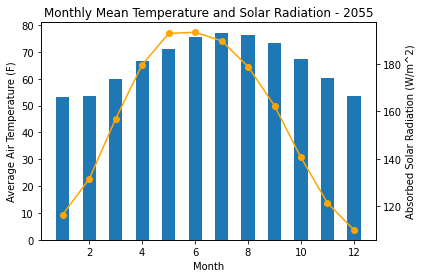

In [431]:
#Plot the monthly distribution of mean temperature
monthly_2055 = df_2055.groupby("month")
fsa_monthly2055 = monthly_2055['FSA'].mean()
fsa_monthly2055=fsa_monthly2055.to_frame()
mean_monthly2055 = monthly_2055['TSA (F)'].mean()
mean_monthly2055 = mean_monthly2055.reset_index()

fig7 = plt.figure()
ax = fig7.add_subplot(111)
ax.bar(mean_monthly2055.month,mean_monthly2055['TSA (F)'].values, width=0.5)
ax2 = fig7.add_subplot(111)
ax2 = ax.twinx()
ax2.plot(mean_monthly2055.month,fsa_monthly2055['FSA'].values, marker='o', color='orange')
ax.set_xlabel('Month')
ax.set_ylabel('Average Air Temperature (F)')
ax2.set_ylabel('Absorbed Solar Radiation (W/m^2)')
plt.title('Monthly Mean Temperature and Solar Radiation - 2055');

C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


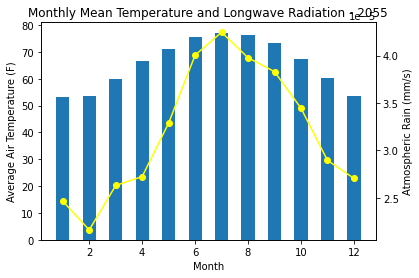

In [432]:
rain_monthly2055 = monthly_2055['RAIN'].mean()
rain_monthly2055=rain_monthly2055.to_frame()
fig8 = plt.figure()
ax = fig8.add_subplot(111)
ax.bar(mean_monthly2055.month,mean_monthly2055['TSA (F)'].values, width=0.5)
ax2 = fig8.add_subplot(111)
ax2 = ax.twinx()
ax2.plot(mean_monthly2055.month,rain_monthly2055['RAIN'].values, marker='o', color='yellow')
ax.set_xlabel('Month')
ax.set_ylabel('Average Air Temperature (F)')
ax2.set_ylabel('Atmospheric Rain (mm/s)')
plt.title('Monthly Mean Temperature and Longwave Radiation - 2055');

There are no obvious differences observable comparing these figures to those for 2015.

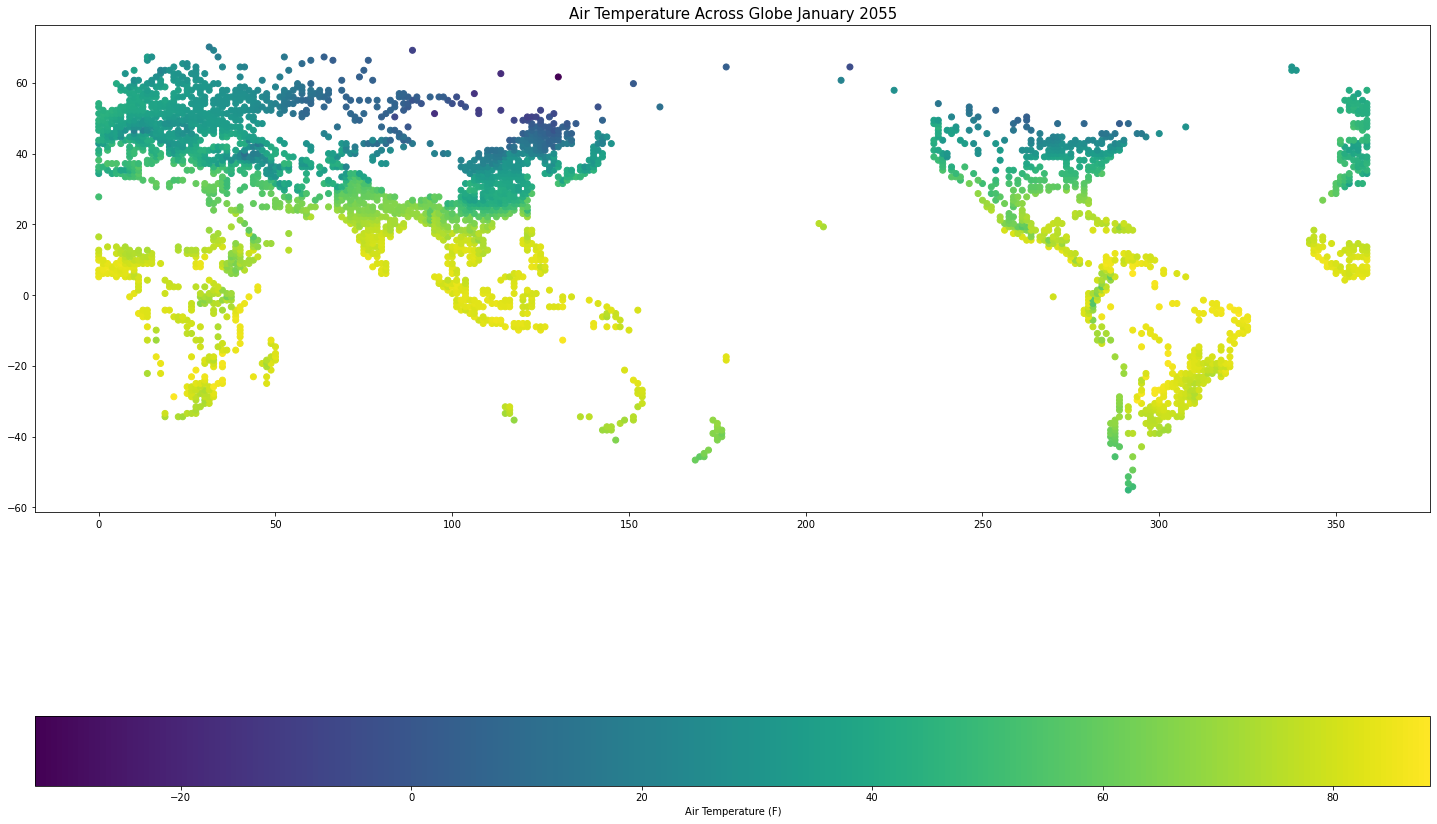

In [421]:
#Map for January
tsa2055_01 = geo_temp2055[geo_temp2055.month ==1]
tsa2055_01 = gpd.GeoDataFrame(tsa2055_01, geometry = points)
tsa2055_01.plot(column='TSA (F)', figsize=(25,25), legend=True, legend_kwds={'label': "Air Temperature (F)","orientation":"horizontal"})
plt.title('Air Temperature Across Globe January 2055', fontsize=15);

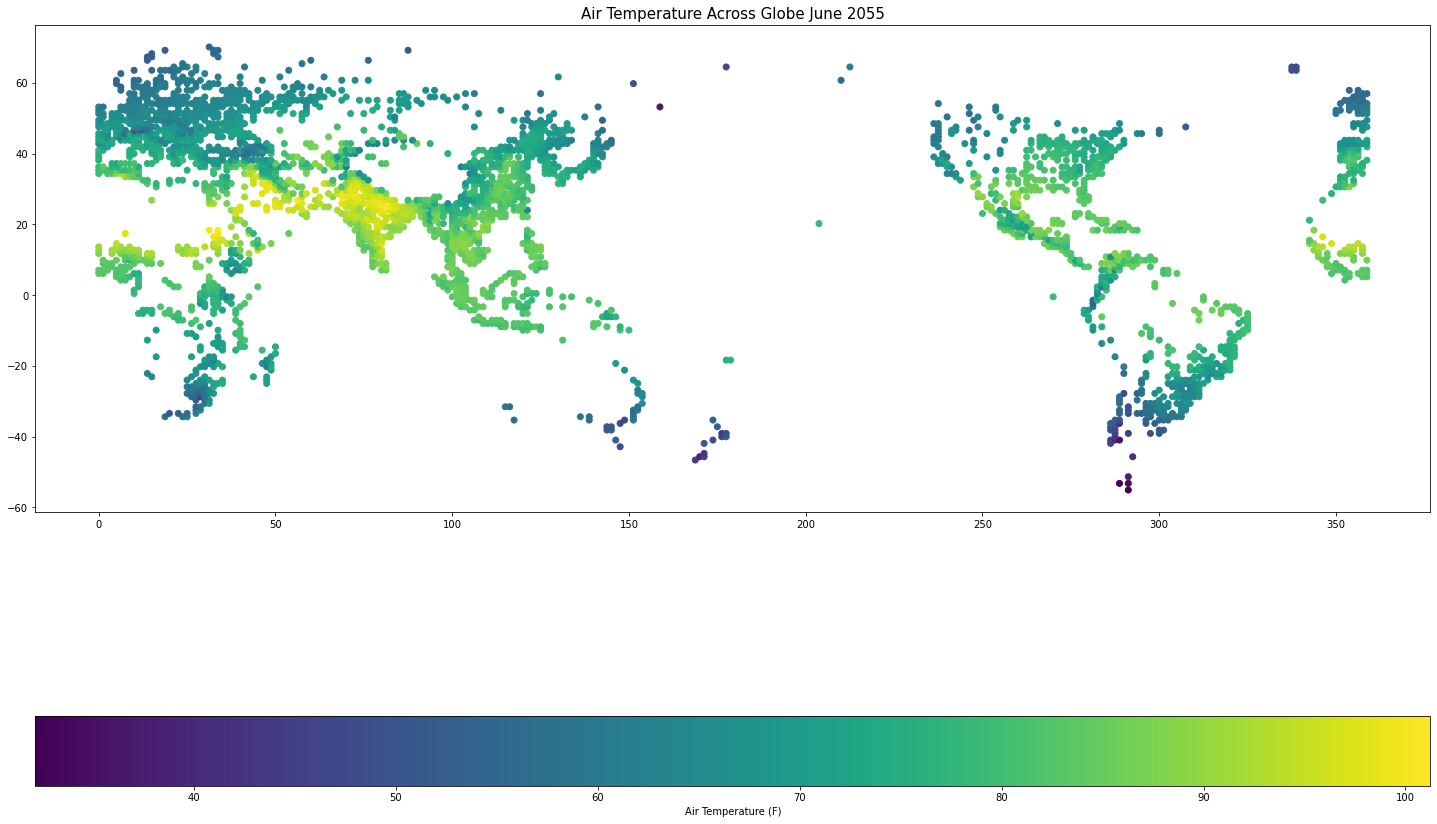

In [422]:
#Map for June
tsa2055_06 = geo_temp2055[geo_temp2055.month ==6]
tsa2055_06 = gpd.GeoDataFrame(tsa2055_06, geometry = points)

tsa2055_06.plot(column='TSA (F)', figsize=(25,25), legend=True, legend_kwds={'label': "Air Temperature (F)","orientation":"horizontal"})
plt.title('Air Temperature Across Globe June 2055', fontsize=15);

The maps above demonstrate a similar trend to those from 2015. However, for the January map, there are warmer temperatures depicted at higher latitudes. Below around 30 degrees, the temperature is in the yellow range. Similarly, in the June map, the warmer temperatures are shown in the center of the globe between 30 and 0 degrees, a widening yellow band compared to 2015. In particular, the Indian subcontinent appears to be warming.

### Analysis of 2095

In [423]:
df_2095=df_nona[df_nona['year']==2095]
df_2096=df_nona[df_nona['year']==2096]
df_2096['year']=2095
df_2096['month']=12
df_2095 = df_2095.append(df_2096)
df_2095.head()

C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,lat,lon,time,mcdate,FIRE_ICE,SOILWATER_10CM,SWBGT,SWBGT_R,SWBGT_U,TBOT,...,HUMIDEX,FSA,FSDS,FLDS,RAIN,PBOT,QBOT,year,month,TSA (F)
356446,-55.130890,291.25,2095-02-01 00:00:00,20950201.0,360.36640,32.633644,13.559496,13.571449,13.714662,282.69730,...,10.018441,134.12558,160.20567,316.35092,0.000015,95929.770,0.006399,2095,1,49.917308
356447,-53.246075,288.75,2095-02-01 00:00:00,20950201.0,370.80527,20.339994,15.514352,15.513229,15.752749,285.60330,...,13.331626,155.16396,181.48630,322.01086,0.000015,96730.260,0.007011,2095,1,54.903074
356448,-53.246075,291.25,2095-02-01 00:00:00,20950201.0,NaN,15.027883,16.022220,16.015842,16.305150,286.41757,...,14.226176,192.46720,225.16037,321.40332,0.000006,98278.266,0.006930,2095,1,56.504840
356449,-51.361256,291.25,2095-02-01 00:00:00,20950201.0,NaN,25.106846,16.907610,16.905365,17.119081,286.93906,...,15.636909,189.54369,223.70644,329.97067,0.000008,100064.180,0.007462,2095,1,57.947936
356450,-49.476440,292.50,2095-02-01 00:00:00,20950201.0,NaN,15.830567,19.472660,19.471233,19.567354,290.31735,...,19.960909,213.15819,251.83435,341.23510,0.000021,100022.360,0.008417,2095,1,64.278032


In [424]:
points = df_2095.apply(lambda row: Point(row.lon, row.lat), axis=1)
geo_temp2095 = gpd.GeoDataFrame(df_2095, geometry=points)
geo_temp2095.set_crs(epsg=4326)
geo_temp2095.time = pd.to_datetime(geo_temp2095.time)
geo_temp2095.head()

,lat,lon,time,mcdate,FIRE_ICE,SOILWATER_10CM,SWBGT,SWBGT_R,SWBGT_U,TBOT,...,FSA,FSDS,FLDS,RAIN,PBOT,QBOT,year,month,TSA (F),geometry
356446,-55.130890,291.25,2095-02-01,20950201.0,360.36640,32.633644,13.559496,13.571449,13.714662,282.69730,...,134.12558,160.20567,316.35092,0.000015,95929.770,0.006399,2095,1,49.917308,POINT (291.250 -55.131)
356447,-53.246075,288.75,2095-02-01,20950201.0,370.80527,20.339994,15.514352,15.513229,15.752749,285.60330,...,155.16396,181.48630,322.01086,0.000015,96730.260,0.007011,2095,1,54.903074,POINT (288.750 -53.246)
356448,-53.246075,291.25,2095-02-01,20950201.0,NaN,15.027883,16.022220,16.015842,16.305150,286.41757,...,192.46720,225.16037,321.40332,0.000006,98278.266,0.006930,2095,1,56.504840,POINT (291.250 -53.246)
356449,-51.361256,291.25,2095-02-01,20950201.0,NaN,25.106846,16.907610,16.905365,17.119081,286.93906,...,189.54369,223.70644,329.97067,0.000008,100064.180,0.007462,2095,1,57.947936,POINT (291.250 -51.361)
356450,-49.476440,292.50,2095-02-01,20950201.0,NaN,15.830567,19.472660,19.471233,19.567354,290.31735,...,213.15819,251.83435,341.23510,0.000021,100022.360,0.008417,2095,1,64.278032,POINT (292.500 -49.476)


C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


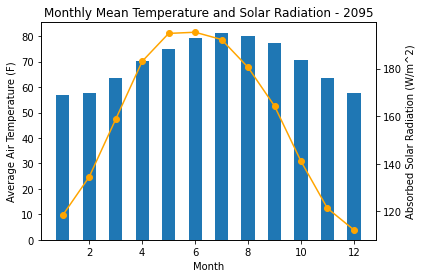

In [433]:
#Plot the monthly distribution of mean temperature
monthly_2095 = df_2095.groupby("month")
fsa_monthly2095 = monthly_2095['FSA'].mean()
fsa_monthly2095=fsa_monthly2095.to_frame()
mean_monthly2095 = monthly_2095['TSA (F)'].mean()
mean_monthly2095 = mean_monthly2095.reset_index()

fig9 = plt.figure()
ax = fig9.add_subplot(111)
ax.bar(mean_monthly2095.month,mean_monthly2095['TSA (F)'].values, width=0.5)
ax2 = fig9.add_subplot(111)
ax2 = ax.twinx()
ax2.plot(mean_monthly2095.month,fsa_monthly2095['FSA'].values, marker='o', color='orange')
ax.set_xlabel('Month')
ax.set_ylabel('Average Air Temperature (F)')
ax2.set_ylabel('Absorbed Solar Radiation (W/m^2)')
plt.title('Monthly Mean Temperature and Solar Radiation - 2095');

C:\Users\ckpch\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


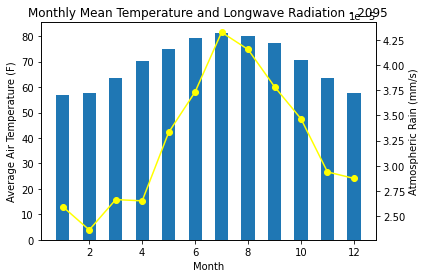

In [434]:
rain_monthly2095 = monthly_2095['RAIN'].mean()
rain_monthly2095=rain_monthly2095.to_frame()
fig10 = plt.figure()
ax = fig10.add_subplot(111)
ax.bar(mean_monthly2095.month,mean_monthly2095['TSA (F)'].values, width=0.5)
ax2 = fig10.add_subplot(111)
ax2 = ax.twinx()
ax2.plot(mean_monthly2095.month,rain_monthly2095['RAIN'].values, marker='o', color='yellow')
ax.set_xlabel('Month')
ax.set_ylabel('Average Air Temperature (F)')
ax2.set_ylabel('Atmospheric Rain (mm/s)')
plt.title('Monthly Mean Temperature and Longwave Radiation - 2095');

Again, these figures show similar patterns across years. There is a strong pattern of atmospheric rainfall peaking in July, which also relates to the highest temperature.

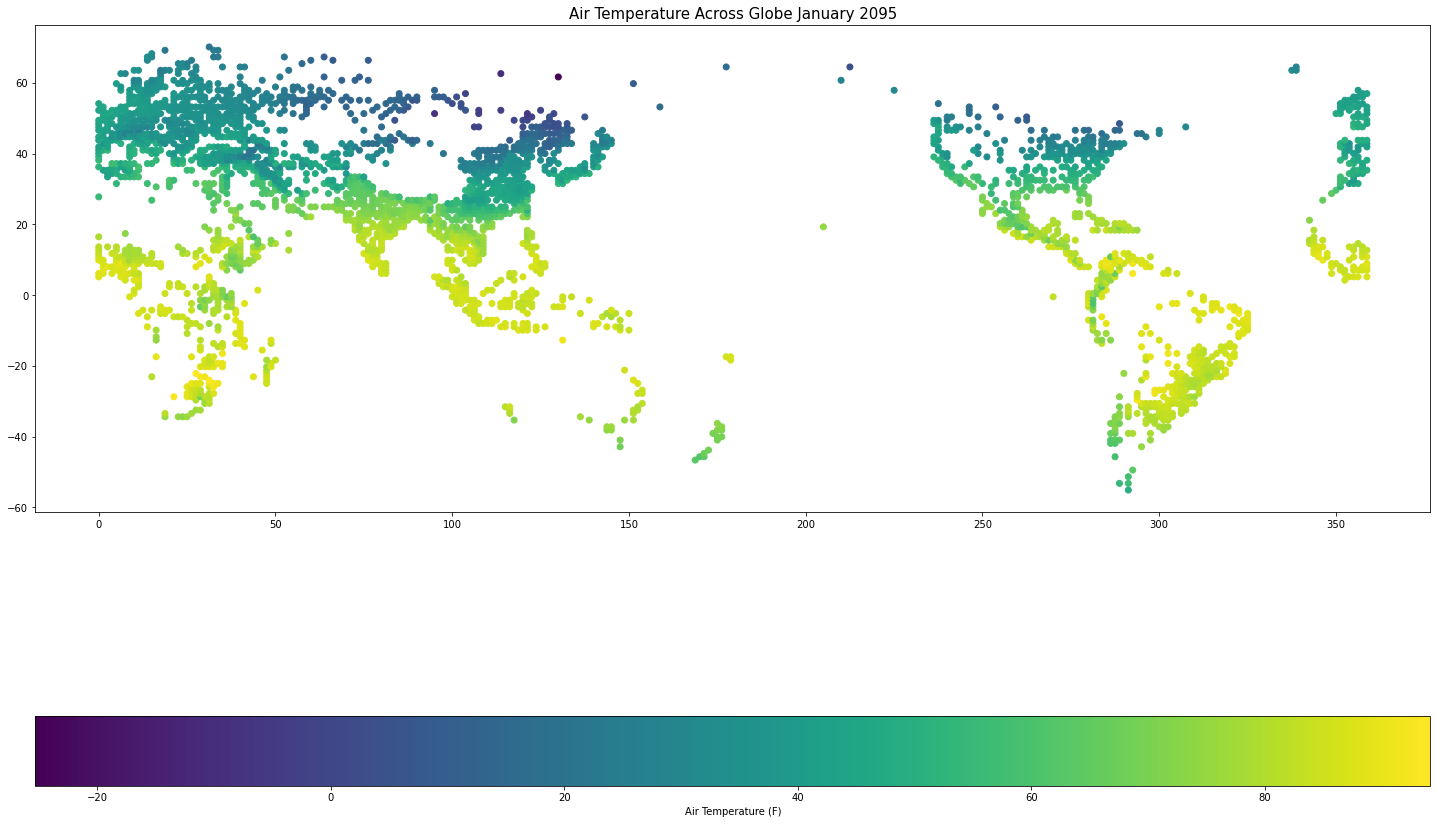

In [425]:
#Map for January
tsa2095_01 = geo_temp2095[geo_temp2095.month ==1]
tsa2095_01 = gpd.GeoDataFrame(tsa2095_01, geometry = points)
tsa2095_01.plot(column='TSA (F)', figsize=(25,25), legend=True, legend_kwds={'label': "Air Temperature (F)","orientation":"horizontal"})
plt.title('Air Temperature Across Globe January 2095', fontsize=15);

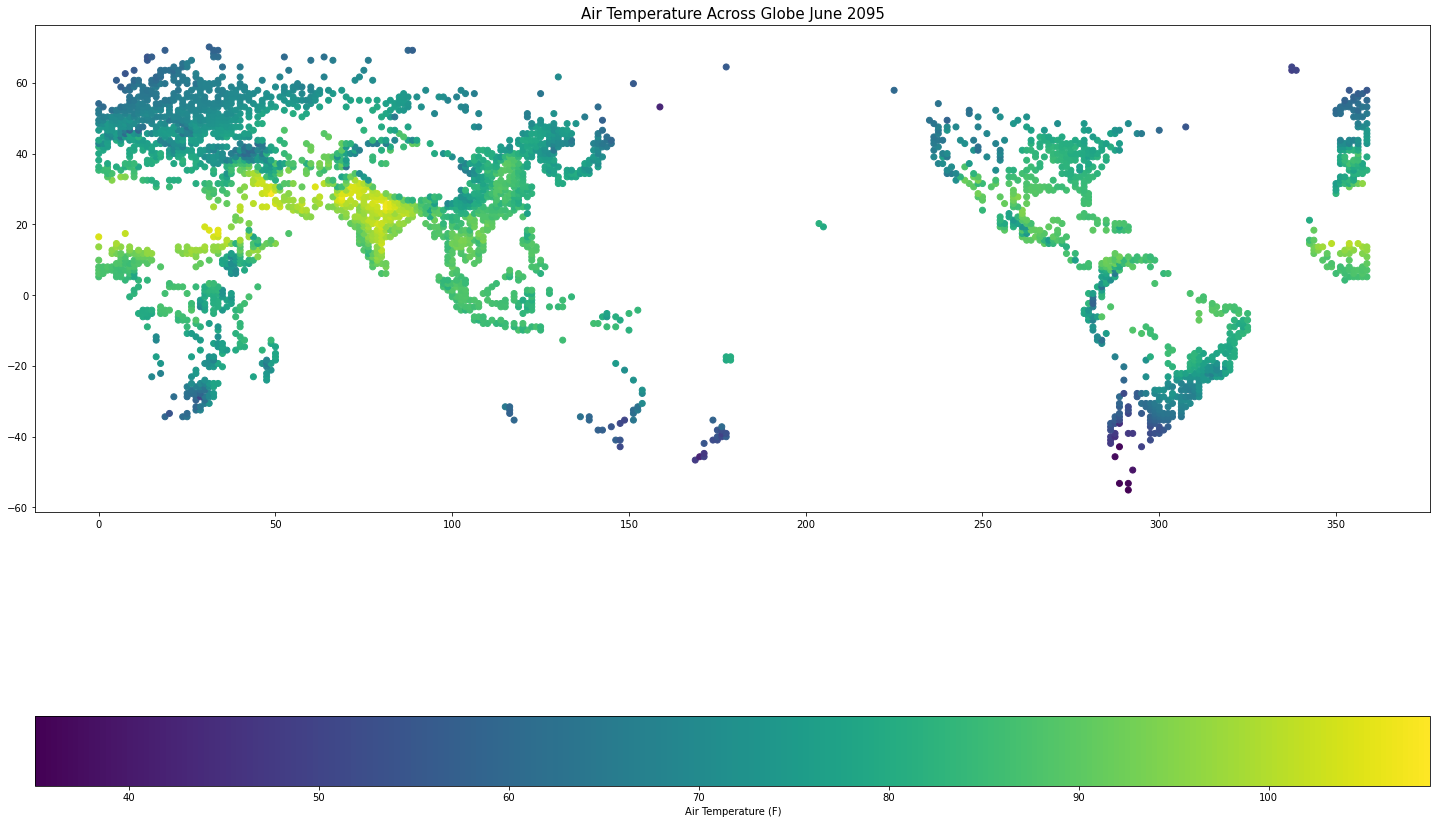

In [426]:
#Map for June
tsa2095_06 = geo_temp2095[geo_temp2095.month ==6]
tsa2095_06 = gpd.GeoDataFrame(tsa2095_06, geometry = points)

tsa2095_06.plot(column='TSA (F)', figsize=(25,25), legend=True, legend_kwds={'label': "Air Temperature (F)","orientation":"horizontal"})
plt.title('Air Temperature Across Globe June 2095', fontsize=15);

Surprisingly, the maps for 2095 do not look markedly different from the maps for 2055, although these deserve greater analytical measures to see if there are differences. The trend remains very similar. It is also possible to see in these maps that the number of data points in the northern hemisphere outweighs the points in the southern hemisphere, which will necessitate a differentiation based on latitude to prevent the measurements from the northern hemisphere dominating the mean measurements.

## Results

The Exploratory Data Analysis completed on the training dataset of outputs from the CESM climate model allowed for the discovery of important data gaps and trends. We determined the variables with the highest correlation with air temperature, which is the variable that the model will aim to replicate. With the results of this correlation analysis combined with background knowledge, the large data set was cut down to the most relevant variables for analysis. Then, the data quality was improved by finding and removing a large number of outliers for 2035 that would have skewed the data. With these removed, the analysis found out more about how temperature has changed over the span of the projections to determine the max, min, and mean temperature in each year. Then three periods were examined (the first year - 2015, the middle - 2055, and the last year - 2095). For each of these subsets of data, we created visualizations to compare the monthly variability in temperature to other variables and learn more about the relationships displayed. In addition, all of the points were mapped across the globe to distinguish spatial variability as well as temporal variability.

There is still further analysis that should be done to find out more about the underlying causes of the observed relationships between various independent variables and air temperature. Given the strong correlation between air temperature and other temperature-related variables, and the weaker relationship with variables like solar radiation, the analysis reveals the need for greater spatial analysis. We need to continue dividing down the areas by latitude and examining the drivers of temperature for each latitude to see if their are higher correlations with solar radiation.

We will continue to do further feature engineering while building the model to understand the causation relationships between model inputs and outputs that would be appropriate for predicting temperature.